In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import glob
import os
import string
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import splprep, splev
from pyproj import Transformer

start_date = np.datetime64('2024-09-25 00:00:00')
end_date = np.datetime64('2024-09-28 00:00:00')

# read COAWST model results
# John's Helene hindcast
url = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Helene2024/rehindcast2/Output/coawst_gomsab_his.nc'

dsm = xr.open_dataset(url)
latm = dsm.lat_rho.values
lonm = dsm.lon_rho.values
time_all = dsm.ocean_time.values
idxms = int( np.where(time_all >= start_date)[0][0] )
idxme = int( np.where(time_all <= end_date)[0][-1] )
timem = time_all[idxms:idxme]
mask_rho = dsm.mask_rho.values
# TODO - change the time of the wet-dry mask
#wd_mask_rho = dsm.wetdry_mask_rho[19,:,:].values
wd_mask_rho = dsm.mask_rho[:,:].values

# Find closest model grid point
# Calculate the difference between the model grid points and the buoy locations; find model indices to closest points
model_shape = np.shape( lonm )
print('model shape: ',model_shape)
print('nlat, nlon: ',np.shape(mask_rho))


model shape:  (512, 833)
nlat, nlon:  (512, 833)


In [2]:
# Extract the depth, latitude, longitude, and mask (0=land, 1=water)
h = dsm['h'].values
lat = dsm['lat_rho'].values
lon = dsm['lon_rho'].values
mask = wd_mask_rho

In [3]:
# Model grid: lon_grid, lat_grid (2D arrays)
# convert to UTM
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32617", always_xy=True)
xm, ym = transformer.transform(lon, lat)
# find differences in model grid spacing
dxm = np.diff(xm)
dym = np.diff(ym)
print('Model spacing: xmean {:.1f}, xmin {:.1f} xmax {:.1f}'.format( np.mean(dxm), np.min(dxm), np.max(dxm) ) )
print('Model spacing: ymean {:.1f}, ymin {:.1f} ymax {:.1f}'.format( np.mean(dym), np.min(dym), np.max(dym) ) )

Model spacing: xmean 1491.1, xmin 1351.1 xmax 1601.2
Model spacing: ymean 727.2, ymin 612.1 ymax 835.3


Text(0, 0.5, 'Latitude')

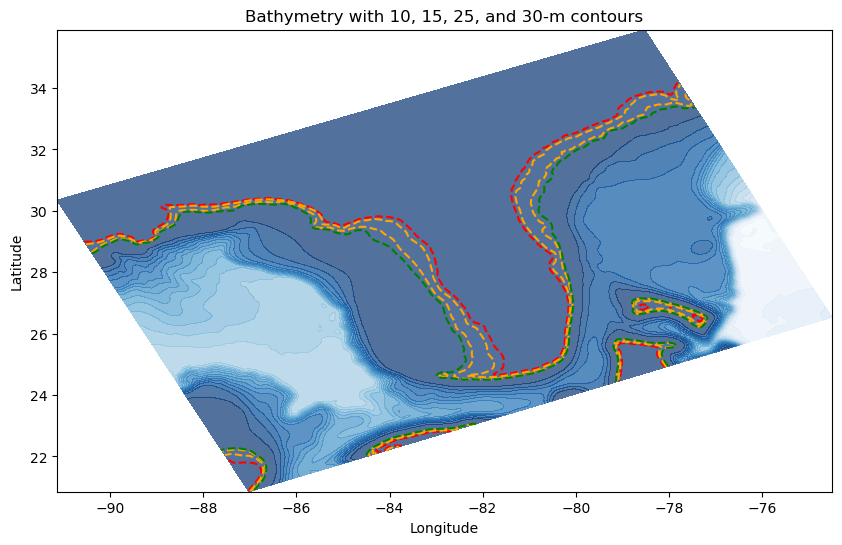

In [4]:
# Plot the depth and  contour
plt.figure(figsize=(10, 6))
plt.contourf(lon, lat, -h, levels=20, cmap='Blues', alpha=0.7)
_ = plt.contour(lon, lat, -h, levels=[-10], colors='red')
contour_15 = plt.contour(lon, lat, -h, levels=[-15], colors='orange')
contour_25 = plt.contour(lon, lat, -h, levels=[-25], colors='orange')
contour_30 = plt.contour(lon, lat, -h, levels=[-30], colors='green')

plt.title(f"Bathymetry with 10, 15, 25, and 30-m contours")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Text(0, 0.5, 'Northing (m)')

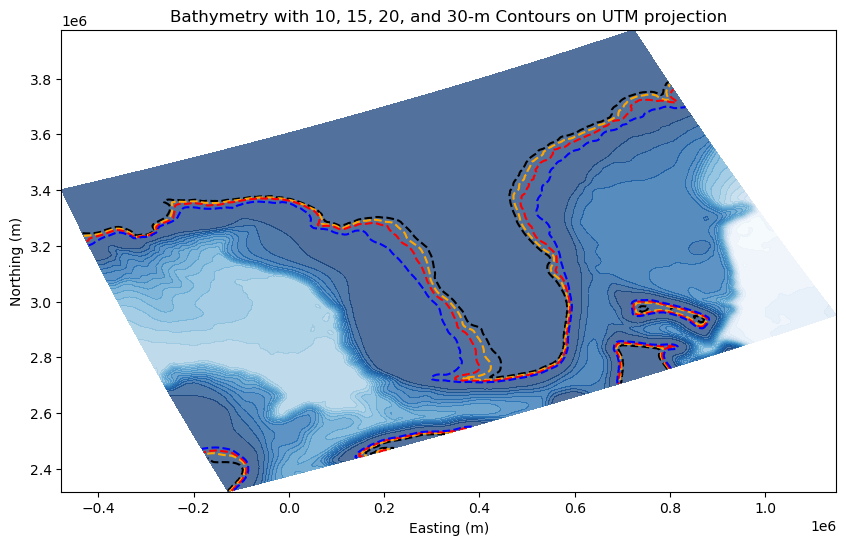

In [5]:
# Plot the depth and  contour
plt.figure(figsize=(10, 6))
plt.contourf(xm, ym, -h, levels=20, cmap='Blues', alpha=0.7)
_ = plt.contour(xm, ym, -h, levels=[-10], colors='black')
contour_15 = plt.contour(xm, ym, -h, levels=[-15], colors='orange')
contour_20 = plt.contour(xm, ym, -h, levels=[-20], colors='red')
contour_30 = plt.contour(xm, ym, -h, levels=[-30], colors='blue')
plt.title(f"Bathymetry with 10, 15, 20, and 30-m Contours on UTM projection")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")

Contour 0: 2686 points
contour15 point spacing: mean 1559.2, min 2.2 max 2705.6
Contour 0: 2733 points
contour20 point spacing: mean 1579.2, min 2.1 max 2803.2
Contour 0: 2723 points
contour30 point spacing: mean 1543.0, min 5.9 max 2778.9


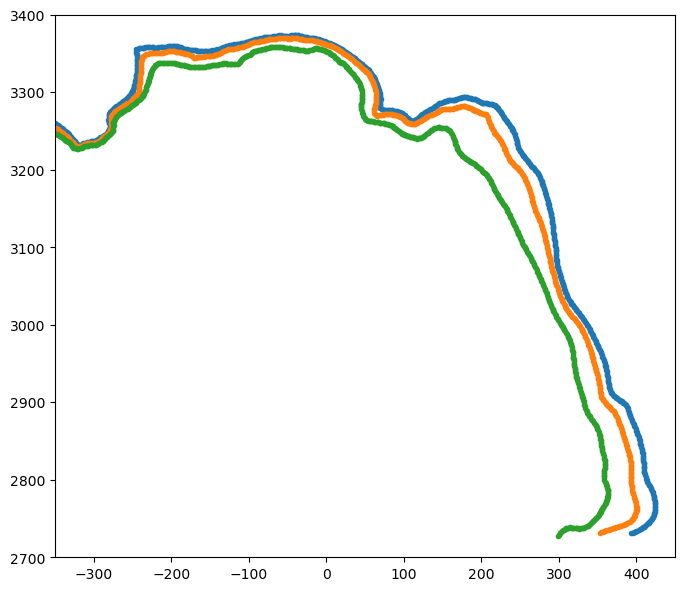

In [6]:
# Extract the vertices from the contour
contour_paths = contour_15.get_paths()
for i, path in enumerate(contour_paths):
    vertices = path.vertices
    print(f"Contour {i}: {vertices.shape[0]} points")

# After some fiddling, this looks like the region we need
contour15 = vertices[522:1450,:]

# Compute distances along the contour
dxyc = np.diff(contour15, axis=0)
delc = np.linalg.norm( dxyc, axis=1 )
print('contour15 point spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(delc), np.min(delc), np.max(delc) ) )

contour_paths = contour_20.get_paths()
for i, path in enumerate(contour_paths):
    vertices = path.vertices
    print(f"Contour {i}: {vertices.shape[0]} points")

# After messing around, these are the points we want:
contour20 = vertices[600:1480,:]

# Compute distances along the contour
dxyc = np.diff(contour20, axis=0)
delc = np.linalg.norm( dxyc, axis=1 )
print('contour20 point spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(delc), np.min(delc), np.max(delc) ) )

contour_paths = contour_30.get_paths()
for i, path in enumerate(contour_paths):
    vertices = path.vertices
    print(f"Contour {i}: {vertices.shape[0]} points")

# After messing around, these are the points we want:
contour30 = vertices[600:1480,:]

# Compute distances along the contour
dxyc = np.diff(contour30, axis=0)
delc = np.linalg.norm( dxyc, axis=1 )
print('contour30 point spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(delc), np.min(delc), np.max(delc) ) )

fig, ax = plt.subplots(1,1, figsize=(8,8) )
ax.plot(contour15[:,0]/1000, contour15[:,1]/1000,'.')
ax.plot(contour20[:,0]/1000, contour20[:,1]/1000,'.')
ax.plot(contour30[:,0]/1000, contour30[:,1]/1000,'.')
ax.set_xlim( -350, 450 )
ax.set_ylim( 2700, 3400 )
ax.set_aspect('equal', adjustable='box')

In [7]:
# 15-m contour
# Apply Gaussian smoothing to the coordinates
sigma = 20  # Smoothing parameter (higher = smoother)
contour15s = np.column_stack((
    gaussian_filter1d(contour15[:, 0], sigma=sigma),  # Smooth longitude
    gaussian_filter1d(contour15[:, 1], sigma=sigma)   # Smooth latitude
))

# Fit parametric spline (no smoothing)
tck, u = splprep([contour15s[:,0], contour15s[:,1]], s=0)

# Determine how many values are needed
contour_len = np.sum(np.linalg.norm(np.diff(contour15s, axis=0), axis=1))
delta = 2000
n_interp = int( contour_len / delta )+1 # fudge factor to get closer to 2000
print('Contour length (m): ', contour_len,'n points: ',n_interp)

# Create new u values for target spacing
u_new = np.linspace(0, 1, n_interp)

# Evaluate spline
x_new, y_new = splev(u_new, tck)
contour15sp = np.column_stack((x_new, y_new))

# Compute distances along the contour
delc = np.linalg.norm( np.diff(contour15sp, axis=0), axis=1 )
print('contour15sp spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(delc), np.min(delc), np.max(delc) ) )

Contour length (m):  1299417.2066371338 n points:  650
contour15sp spacing: mean 2002.2, min 2002.0 max 2002.2


In [8]:
# Repeat for 20-m contour
# Apply Gaussian smoothing to the coordinates
sigma = 20  # Smoothing parameter (higher = smoother)
contour20s = np.column_stack((
    gaussian_filter1d(contour20[:, 0], sigma=sigma),  # Smooth longitude
    gaussian_filter1d(contour20[:, 1], sigma=sigma)   # Smooth latitude
))

# Fit parametric spline (no smoothing)
tck, u = splprep([contour20s[:,0], contour20s[:,1]], s=0)

# Determine how many values are needed
contour_len = np.sum(np.linalg.norm(np.diff(contour20s, axis=0), axis=1))
delta = 2000
n_interp = int( contour_len / delta )+1 # fudge factor to get closer to 2000
print('Contour length (m): ', contour_len,'n points: ',n_interp)

# Create new u values for target spacing
u_new = np.linspace(0, 1, n_interp)

# Evaluate spline
x_new, y_new = splev(u_new, tck)
contour20sp = np.column_stack((x_new, y_new))

# Compute distances along the contour
delc = np.linalg.norm( np.diff(contour20sp, axis=0), axis=1 )
print('contour20sp spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(delc), np.min(delc), np.max(delc) ) )

Contour length (m):  1240380.5186930185 n points:  621
contour20sp spacing: mean 2000.6, min 2000.5 max 2000.6


In [9]:
# Repeat for 30-m contour
# Apply Gaussian smoothing to the coordinates
sigma = 20  # Smoothing parameter (higher = smoother)
contour30s = np.column_stack((
    gaussian_filter1d(contour30[:, 0], sigma=sigma),  # Smooth longitude
    gaussian_filter1d(contour30[:, 1], sigma=sigma)   # Smooth latitude
))

# Fit parametric spline (no smoothing)
tck, u = splprep([contour30s[:,0], contour30s[:,1]], s=0)

# Determine how many values are needed
contour_len = np.sum(np.linalg.norm(np.diff(contour30s, axis=0), axis=1))
delta = 2000
n_interp = int( contour_len / delta )+1 # fudge factor to get closer to 2000
print('Contour length (m): ', contour_len,'n points: ',n_interp)

# Create new u values for target spacing
u_new = np.linspace(0, 1, n_interp)

# Evaluate spline
x_new, y_new = splev(u_new, tck)
contour30sp = np.column_stack((x_new, y_new))

# Compute distances along the contour
delc = np.linalg.norm( np.diff(contour30sp, axis=0), axis=1 )
print('contour30sp spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(delc), np.min(delc), np.max(delc) ) )# Repeat for 30-m contour

Contour length (m):  1220275.119416454 n points:  611
contour30sp spacing: mean 2000.4, min 2000.3 max 2000.5


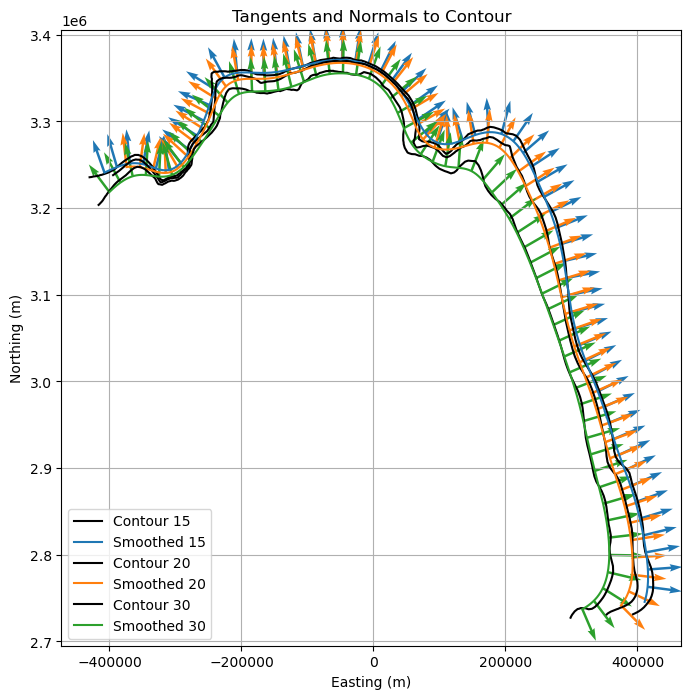

In [10]:
# Compute tangents
tangents15 = np.gradient(contour15sp, axis=0)  # Forward/backward difference for each point
tangents20 = np.gradient(contour20sp, axis=0)  # Forward/backward difference for each point
tangents30 = np.gradient(contour30sp, axis=0)  # Forward/backward difference for each point

# Normalize tangents
tangents_norm15 = np.linalg.norm(tangents15, axis=1, keepdims=True)
tangents_unit15 = tangents15 / tangents_norm15

tangents_norm20 = np.linalg.norm(tangents20, axis=1, keepdims=True)
tangents_unit20 = tangents20 / tangents_norm20

tangents_norm30 = np.linalg.norm(tangents30, axis=1, keepdims=True)
tangents_unit30 = tangents30 / tangents_norm30

# Compute normals
normals15 = np.zeros_like(tangents15)
normals15[:, 0] = tangents_unit15[:, 1]  # ty -> nx (swap and change sign)
normals15[:, 1] = -tangents_unit15[:, 0] # -tx -> ny

normals20 = np.zeros_like(tangents20)
normals20[:, 0] = tangents_unit20[:, 1]  # ty -> nx (swap and change sign)
normals20[:, 1] = -tangents_unit20[:, 0] # -tx -> ny

normals30 = np.zeros_like(tangents30)
normals30[:, 0] = tangents_unit30[:, 1]  # ty -> nx (swap and change sign)
normals30[:, 1] = -tangents_unit30[:, 0] # -tx -> ny

# Visualize tangents and normals
plt.figure(figsize=(8, 8))
plt.plot(contour15[:, 0], contour15[:, 1], 'k-', label='Contour 15')
plt.plot(contour15sp[:, 0], contour15sp[:, 1], '-', c='tab:blue', label='Smoothed 15')
plt.plot(contour20[:, 0], contour20[:, 1], 'k-', label='Contour 20')
plt.plot(contour20sp[:, 0], contour20sp[:, 1], '-', c='tab:orange', label='Smoothed 20')
plt.plot(contour30[:, 0], contour30[:, 1], 'k-', label='Contour 30')
plt.plot(contour30sp[:, 0], contour30sp[:, 1], '-', c='tab:green', label='Smoothed 30')

# Plot the normals, flip the normals by changing signs, plot every skip
skip = 10
plt.quiver(
    contour15sp[::skip, 0], contour15sp[::skip, 1], -normals15[::skip, 0], -normals15[::skip, 1],
    color = 'tab:blue', width = .004)
plt.quiver(
    contour20sp[::skip, 0], contour20sp[::skip, 1], -normals20[::skip, 0], -normals20[::skip, 1],
    color = 'tab:orange', width = .004)
plt.quiver(
    contour30sp[::skip, 0], contour30sp[::skip, 1], -normals30[::skip, 0], -normals30[::skip, 1],
    color = 'tab:green', width = .004)
#    color='b', angles='xy', scale_units='xy', scale=2, width=.002, label='Normals')
plt.ylabel('Northing (m)')
plt.xlabel('Easting (m)')
plt.legend()
plt.title('Tangents and Normals to Contour')
plt.grid()
plt.show()

In [11]:
def write_kml_line(lat, lon, filename="line.kml", name="My Line"):
    """
    Write a KML file with a LineString from lat/lon arrays.
    
    Parameters
    ----------
    lat : array-like
        List or array of latitudes.
    lon : array-like
        List or array of longitudes.
    filename : str
        Output filename for the KML file.
    name : str
        Name of the Placemark in KML.

    ChatGPT 5
    """
    
    # Build coordinates block (lon,lat)
    coords = "\n          ".join([f"{lo},{la}" for lo, la in zip(lon, lat)])
    
    kml_template = f"""<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2">
  <Document>
    <Placemark>
      <name>{name}</name>
      <Style>
        <LineStyle>
          <color>ff0000ff</color> <!-- red line (aabbggrr format) -->
          <width>3</width>
        </LineStyle>
      </Style>
      <LineString>
        <tessellate>1</tessellate>
        <coordinates>
          {coords}
        </coordinates>
      </LineString>
    </Placemark>
  </Document>
</kml>
"""
    
    with open(filename, "w") as f:
        f.write(kml_template)
    print(f"KML file written to {filename}")

In [12]:
# Set up coordinate conversion
transformerT = Transformer.from_crs("EPSG:32617", "EPSG:4326", always_xy=True)

# 15-m contour
contour15sp_lon, contour15sp_lat = transformerT.transform(contour15sp[:,0], contour15sp[:,1] )
# Trim between Mobile Bay and Marco Island (south of Naples)
isrt = int( np.argwhere(contour15sp_lon > -88.0)[0] )
iend = int( np.argwhere(contour15sp_lat > 25.5)[-1] )
print(isrt, iend)

# Create DataFrame
df = pd.DataFrame({
    "contour15s_lon": contour15sp_lon[isrt:iend],
    "contour15s_lat": contour15sp_lat[isrt:iend],
    "contour15s_x":contour15sp[isrt:iend,0],
    "contour15s_y":contour15sp[isrt:iend,1],
    "normals15_x": -normals15[isrt:iend,0],
    "normals15_y": -normals15[isrt:iend,1]
})
# Save to CSV
df.to_csv("contour15sp.csv", index=False)
print("CSV file saved as contour15sp.csv")
# Save to KML
write_kml_line(contour15sp_lat[isrt:iend], contour15sp_lon[isrt:iend], filename="contour15sp.kml", name="15m_contour")


# 20-m contour
contour20sp_lon, contour20sp_lat = transformerT.transform(contour20sp[:,0], contour20sp[:,1] )
# Trim between Mobile Bay and Marco Island (south of Naples
isrt = int( np.argwhere(contour20sp_lon > -88.0)[0] )
iend = int( np.argwhere(contour20sp_lat > 25.5)[-1] )
print(isrt, iend)
# Create DataFrame
df = pd.DataFrame({
    "contour20s_lon": contour20sp_lon[isrt:iend],
    "contour20s_lat": contour20sp_lat[isrt:iend],
    "contour20s_x":contour20sp[isrt:iend,0],
    "contour20s_y":contour20sp[isrt:iend,1],
    "normals20_x": -normals20[isrt:iend,0],
    "normals20_y": -normals20[isrt:iend,1]
})
# Save to CSV
df.to_csv("contour20sp.csv", index=False)
print("CSV file saved as contour20sp.csv")
# Save to KML
write_kml_line(contour20sp_lat[isrt:iend], contour20sp_lon[isrt:iend], filename="contour20sp.kml", name="20m_contour")

# 30-m contour
contour30sp_lon, contour30sp_lat = transformerT.transform(contour30sp[:,0], contour30sp[:,1] )
# Trim between Mobile Bay and Marco Island (south of Naples
isrt = int( np.argwhere(contour30sp_lon > -88.0)[0] )
iend = int( np.argwhere(contour30sp_lat > 25.5)[-1] )
print(isrt, iend)
# Create DataFrame
df = pd.DataFrame({
    "contour30s_lon": contour30sp_lon[isrt:iend],
    "contour30s_lat": contour30sp_lat[isrt:iend],
    "contour30s_x":contour30sp[isrt:iend,0],
    "contour30s_y":contour30sp[isrt:iend,1],
    "normals30_x": -normals30[isrt:iend,0],
    "normals30_y": -normals30[isrt:iend,1]
})
# Save to CSV
df.to_csv("contour30sp.csv", index=False)
print("CSV file saved as contour30sp.csv")
# Save to KML
write_kml_line(contour30sp_lat[isrt:iend], contour30sp_lon[isrt:iend], filename="contour30sp.kml", name="30m_contour")

146 610
CSV file saved as contour15sp.csv
KML file written to contour15sp.kml
125 577
CSV file saved as contour20sp.csv
KML file written to contour20sp.kml
134 559
CSV file saved as contour30sp.csv
KML file written to contour30sp.kml


C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_34788\756614961.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  isrt = int( np.argwhere(contour15sp_lon > -88.0)[0] )
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_34788\756614961.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  iend = int( np.argwhere(contour15sp_lat > 25.5)[-1] )
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_34788\756614961.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  isrt =